
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

Le projet a été développé à l'aide de Alice Breton, étudiante à la maîtrise en génie informatique. Elle a suivi le cours lors de la session Hiver 2019.



# Projet : Débordement d'égouts

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/a238b752c33a41d9803c2cdde6bfc929

Ce calepin Jupyter de base permet de charger et de nettoyer les données fournies. La dernière section détaille la génération du fichier des prédictions afin de le soumettre sur Kaggle dans le bon format.

Dans un premier temps, vous devrez récupérer l'archive *data.zip* sur Moodle. Ce dossier contient les fichiers suivants :
- surverses.csv
- precipitation.csv
- ouvrages-surverses.csv
- test.csv

Veuillez le décompresser dans le répertoire de ce calepin.

Le fichier *surverse.csv* répertorie s'il y a surverse (1) ou non (0) au cours de la journée pour les 170 ouvrages de débordement de 2013 à 2018 pour les mois de mai à octobre (inclusivement). Des renseignements additionnels sur les données sont disponibles à l'adresse suivante :

http://donnees.ville.montreal.qc.ca/dataset/debordement


Le fichier *precipitation.csv* contient les précipitations horaires en dixième de *mm* enregistrées à 5 stations pluviométriques de 2013 à 2019 :
- McTavish (7024745)
- Ste-Anne-de-Bellevue (702FHL8)
- Montreal/Pierre Elliott Trudeau Intl (702S006)
- Montreal/St-Hubert (7027329)
- L’Assomption (7014160)

Plus d'informations sur les précipitations sont disponibles à l'adresse suivante :

https://climat.meteo.gc.ca/climate_data/hourly_data_f.html?hlyRange=2008-01-08%7C2019-11-12&dlyRange=2002-12-23%7C2019-11-12&mlyRange=%7C&StationID=30165&Prov=QC&urlExtension=_f.html&searchType=stnName&optLimit=yearRange&StartYear=1840&EndYear=2019&selRowPerPage=25&Line=17&searchMethod=contains&Month=11&Day=12&txtStationName=montreal&timeframe=1&Year=2019

Le fichier *ouvrages-surverses.csv* contient différentes caractéristiques des ouvrages de débordement. 

http://donnees.ville.montreal.qc.ca/dataset/ouvrage-surverse

Le fichier *test.csv* contient les ouvrages et les jours pour lesquels vous devez prédire s'il y a eu surverse (true) ou non (false). Notez que l'on s'intéresse ici à 5 ouvrages de débordement localisés tout autour de l'Ile de Montréal :
- 3260-01D dans Rivière-des-Prairies 
- 3350-07D dans Ahunstic 
- 4240-01D dans Pointe-aux-Trembles 
- 4350-01D dans le Vieux-Montréal 
- 4380-01D dans Verdun

#### Remarque

Dans le projet, on ne s'intéresse qu'aux surverses occasionnées par les précipitations. On ignore les surverses occasionnées par 
- fonte de neige (F)
- travaux planifiés et entretien (TPL)
- urgence (U)
- autre (AUT)

On suppose que lorsqu'il n'y a pas de raison pour la surverse, il s'agit d'une surverse causée par les précipitations. Puisque Nous nous intéresserons uniquement aux surverses occasionnées par les précipitations liquides, nous ne considérons que les mois de mai à octobre inclusivement.

In [270]:
using CSV, DataFrames, Statistics, StatsBase, Dates, Gadfly, Distributions, Random, StatPlots

ArgumentError: ArgumentError: Package StatPlots not found in current path:
- Run `import Pkg; Pkg.add("StatPlots")` to install the StatPlots package.


# Chargement des données et nettoyage préliminaire

## Chargement des surverses

In [271]:
data = CSV.read("data/surverses.csv",missingstring="-99999")
first(data,5);

## Nettoyage des données sur les surverses

#### Extraction des surverses pour les mois de mai à octobre inclusivement

In [272]:
data = filter(row -> month(row.DATE) > 4, data) 
data = filter(row -> month(row.DATE) < 11, data) 
first(data,5);

#### Remplacement des valeurs *missing* dans la colonne :RAISON par "Inconnue"

In [273]:
raison = coalesce.(data[:,:RAISON],"Inconnue")
data[!,:RAISON] = raison
first(data,5);

#### Exlusion des surverses coccasionnées par d'autres facteurs que les précipitations liquides

Ces facteurs correspondent à : 
- la fonte de neige (F), 
- les travaux planifiés et entretien (TPL)
- urgence (U)
- autre (AUT)

In [274]:
data = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], data) 
select!(data, [:NO_OUVRAGE, :DATE, :SURVERSE])
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE
,String,Date,Int64⍰
1,0642-01D,2013-05-01,0
2,0642-01D,2013-05-02,0
3,0642-01D,2013-05-03,0
4,0642-01D,2013-05-04,0
5,0642-01D,2013-05-05,0


#### Exclusion des lignes où :SURVERSE est manquante

In [275]:
surverse_df = dropmissing(data, disallowmissing=true)
first(surverse_df,5)

,NO_OUVRAGE,DATE,SURVERSE
,String,Date,Int64
1,0642-01D,2013-05-01,0
2,0642-01D,2013-05-02,0
3,0642-01D,2013-05-03,0
4,0642-01D,2013-05-04,0
5,0642-01D,2013-05-05,0


## Chargement des précipitations

In [276]:
data = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(data, Symbol("St-Hubert")=>:StHubert);

## Nettoyage des données sur les précipitations

#### Extraction des précipitations des mois de mai à octobre inclusivement

In [277]:
data = filter(row -> month(row.date) > 4, data) 
data = filter(row -> month(row.date) < 11, data) 
first(data,5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-05-01,0,0,0,0,0,missing
2,2013-05-01,1,0,0,0,0,missing
3,2013-05-01,2,0,0,0,0,missing
4,2013-05-01,3,0,0,0,0,missing
5,2013-05-01,4,0,0,0,0,missing


In [278]:
data_missings = copy(data);

## Traitement des missings

In [279]:
# McTavish / Bellevue / Assomption / Trudeau / StHubert
distance = [[0, 2, 3, 1, 1] [2, 0, 5, 1, 3] [3, 5, 0, 4, 3] [1, 1, 4, 0, 2] [1, 3, 3, 2, 0] ];
#distance = [[0, 4, 3, 5, 5] [4, 0, 1, 5, 3] [3, 1, 0, 2, 3] [5, 5, 1, 0, 4] [5, 3, 3, 4, 0] ];
#distance_inv = 1 ./ distance

In [280]:
function getNewVal(i, x)
    newValue = 0
    totalDistance = 1

    if !ismissing(data.McTavish[i])
        newValue = newValue + data.McTavish[i] * distance[x, 1] 
        totalDistance = totalDistance + distance[x, 1]
    end
    if !ismissing(data.Bellevue[i])
        newValue = newValue + data.Bellevue[i] * distance[x, 2] 
        totalDistance = totalDistance + distance[x, 2]
    end
    if !ismissing(data.Assomption[i])
        newValue = newValue + data.Assomption[i] * distance[x, 3]
        totalDistance = totalDistance + distance[x, 3]
    end
    if !ismissing(data.Trudeau[i])
        newValue = newValue + data.Trudeau[i] * distance[x, 4]
        totalDistance = totalDistance + distance[x, 4]
    end
    if !ismissing(data.StHubert[i])
        newValue = newValue + data.StHubert[i] * distance[x, 5]
        totalDistance = totalDistance + distance[x, 5]
    end

    if totalDistance > 1
        totalDistance = totalDistance - 1
    end
        
    return floor(newValue / totalDistance)
end

getNewVal (generic function with 1 method)

In [281]:
function replaceMissing()
    
    for i=1:size(data, 1)
        
        if ismissing(data.McTavish[i])
            data.McTavish[i] = getNewVal(i, 1)
        end
        if ismissing(data.Bellevue[i])
            data.Bellevue[i] = getNewVal(i, 2)
        end
        if ismissing(data.Assomption[i])
            data.Assomption[i] = getNewVal(i, 3)
        end
        if ismissing(data.Trudeau[i])
            data.Trudeau[i] = getNewVal(i, 4)
        end
        if ismissing(data.StHubert[i])
            data.StHubert[i] = getNewVal(i, 5)
        end
    end    
end

replaceMissing (generic function with 1 method)

In [282]:
replaceMissing()

In [283]:
outofbound₁ = filter(row -> row.McTavish > 1000, data)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-10-10,13,2082,0,0,0,231


In [284]:
outofbound₂ = filter(row -> row.Bellevue > 1000, data)
outofbound₃ = filter(row -> row.Assomption > 1000, data)
outofbound₄ = filter(row -> row.Trudeau > 1000, data)
outofbound₅ = filter(row -> row.StHubert > 1000, data)

[size(outofbound₂, 1) size(outofbound₃, 1) size(outofbound₄, 1) size(outofbound₅, 1)]

1×4 Array{Int64,2}:
 0  0  0  0

In [285]:
m = findall(x -> x > 1000, data.McTavish)

1-element Array{Int64,1}:
 3902

In [286]:
for i=1:size(m, 1)
    data.McTavish[m[i]] = getNewVal(m[i], 1)
end

In [287]:
filter(row -> row.McTavish > 1000, data)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰


In [288]:
last(data, 5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2019-10-31,19,0,0,0,0,0
2,2019-10-31,20,0,0,0,0,0
3,2019-10-31,21,0,0,0,0,0
4,2019-10-31,22,0,0,0,0,0
5,2019-10-31,23,0,0,0,0,0


# Analyse exploratoire

Cette section consitue une analyse exploratoire superficielle permettant de voir s'il existe un lien entre les précipitations et les surverses.

Prenons arbitrairement l'ouvrage de débordement près du Bota-Bota (4350-01D). La station météorologique la plus proche est McTavish. Prenons deux variables explicatives simple :
- la somme journalière des précipitations
- le taux horaire maximum journalier de précipitations

#### Calcul de la quantité journalière de précipitations pour chacune des stations météorologiques

In [289]:
pcp_sum = by(data, :date,  McTavish = :McTavish=>sum, Bellevue = :Bellevue=>sum, 
   Assomption = :Assomption=>sum, Trudeau = :Trudeau=>sum, StHubert = :StHubert=>sum)
first(pcp_sum ,5);

#### Extraction du taux horaire journalier maximum des précipitations pour chacune des stations météorologiques

In [290]:
pcp_max = by(data, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)
first(pcp_max,5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2013-05-01,0,0,0,0,0
2,2013-05-02,0,0,0,0,0
3,2013-05-03,0,0,0,0,0
4,2013-05-04,0,0,0,0,0
5,2013-05-05,0,0,0,0,0


#### Somme des trois heures avec le plus de precipitaion

In [291]:
function far(a)
    b = partialsortperm(vec(a), 1:3, rev=true)
    v = collect(zip(b, a[b]))[1][1]
    
    i_avant = v + 1
    i_apres = v + 1
    if v == 0
        
    end
    if v == 23
        
    end 
    
    avant = a[v-1]
    apres = a[v+1]
    
    return avant + apres
end

far (generic function with 1 method)

In [292]:
far([56 0 78 10 0])

10

In [293]:
# pcp_highest = by(data, :date,  McTavish = :McTavish=>far, Bellevue = :Bellevue=>far, 
#     Assomption = :Assomption=>far, Trudeau = :Trudeau=>far, StHubert = :StHubert=>far)
# first(pcp_highest,5)

#### Inclusion dans un dataframe de ces deux variables explicatives potentielles

In [294]:
ouvrage = "4350-01D"

df = filter(row -> row.NO_OUVRAGE == ouvrage, surverse_df)

x₁ = Array{Union{Missing, Int64}}(missing, size(df,1)) # variable pour la somme journalière
x₂ = Array{Union{Missing, Int64}}(missing, size(df,1)) # variable pour le max journalier
# x₃ = Array{Union{Missing, Float64}}(missing, size(df,1)) # variable pour le median journalier


for i=1:size(df,1)
    
    ind = findfirst(pcp_sum[:,:date] .== df[i,:DATE])
    
    x₁[i] = pcp_sum[ind,:McTavish]
    
    ind = findfirst(pcp_max[:,:date] .== df[i,:DATE])
    
    x₂[i] = pcp_max[ind,:McTavish]
    
#      ind = findfirst(pcp_highest[:,:date] .== df[i,:DATE])
    
#      x₃[i] = pcp_highest[ind,:McTavish]
    
end

df[!,:SUM] = x₁
df[!,:MAX] = x₂
# df[!,:TIM] = x₃


dropmissing!(df, [:SUM, :MAX],disallowmissing=true)

first(df,5)

,NO_OUVRAGE,DATE,SURVERSE,SUM,MAX
,String,Date,Int64,Int64,Int64
1,4350-01D,2013-05-01,0,0,0
2,4350-01D,2013-05-02,0,0,0
3,4350-01D,2013-05-03,0,0,0
4,4350-01D,2013-05-04,0,0,0
5,4350-01D,2013-05-05,0,0,0


#### Traçage des distribution de la somme des précipitations en fonction des surverses ou non

On remarque que les deux distributions sont très différentes. Ceci suggère que la somme des précipitations à la station McTavish a un effet sur les surverses au Bota-Bota.

In [295]:
# plot(df, x=:SURVERSE, y=:TIM, Geom.boxplot)

#### Traçage des distribution de la somme des précipitations en fonction des surverses ou non

On remarque que les deux distributions sont très différentes. Ceci suggère que le maximum journalier des précipitations à la station McTavish a un effet sur les surverses au Bota-Bota.

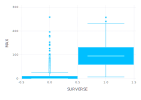

In [296]:
plot(df, x=:SURVERSE, y=:MAX, Geom.boxplot)

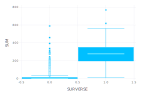

In [297]:
plot(df, x=:SURVERSE, y=:SUM, Geom.boxplot)

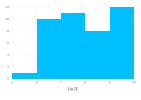

In [298]:
df_month = copy(df)
df_month[!,:DATE] = month.(df_month[!,:DATE])
plot(filter!( row -> row.SURVERSE == 1,df_month), x =:DATE, Geom.histogram)

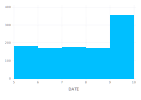

In [299]:
df_month = copy(df)
df_month[!,:DATE] = month.(df_month[!,:DATE])
plot(filter!(row -> row.SURVERSE == 0,df_month), x =:DATE, Geom.histogram)

### Jointure entre le data et les labels

In [300]:
rename!(surverse_df, :DATE => :date)
data_joined_tot_day = join(pcp_sum, surverse_df, on = :date)
first(data_joined_tot_day, 5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert,NO_OUVRAGE,SURVERSE
,Date,Int64,Int64,Int64,Int64,Int64,String,Int64
1,2013-05-01,0,0,0,0,0,0642-01D,0
2,2013-05-01,0,0,0,0,0,0672-01D,0
3,2013-05-01,0,0,0,0,0,0672-02D,0
4,2013-05-01,0,0,0,0,0,0672-03D,0
5,2013-05-01,0,0,0,0,0,0801-01D,0


In [301]:
data_joined_max_day = join(pcp_max, surverse_df, on = :date)
first(data_joined_max_day, 5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert,NO_OUVRAGE,SURVERSE
,Date,Int64,Int64,Int64,Int64,Int64,String,Int64
1,2013-05-01,0,0,0,0,0,0642-01D,0
2,2013-05-01,0,0,0,0,0,0672-01D,0
3,2013-05-01,0,0,0,0,0,0672-02D,0
4,2013-05-01,0,0,0,0,0,0672-03D,0
5,2013-05-01,0,0,0,0,0,0801-01D,0


In [302]:
ouvrages = ["3260-01D" "3350-07D" "4240-01D" "4350-01D" "4380-01D"]
stations = [:McTavish :Bellevue :Assomption :Trudeau :StHubert]
index_ouvrages = Dict{String,Integer}("3260-01D" => 1, "3350-07D" => 2, "4240-01D"=>3, "4350-01D"=>4, "4380-01D"=>5)
index_stations = Dict{String,Integer}("McTavish" => 1, "Bellevue" => 2, "Assomption"=>3, "Trudeau" => 4, "StHubert"=>5)
F_T = [false true]
n_ouvrages = length(ouvrages)
n_station = length(stations)

5

# Definition de l'intervalle de test et d'entrainement

Nous entrainons nos données sur tous l'ensemble des 170 ouvrages alors que le modele n'est entrainé que pour fonctionner sur 5 ouvrages particuliers. Il faudrait donc le prendre en compte, lors de la validation du modèle, et utiliser seulement des données d'une de l'une de des stations faisant partie du modèle. Nous selectionneron donc notre échantillon test parmi les données filtrées suivantes.

In [303]:
x = filter!(row -> row.NO_OUVRAGE ∈ ouvrages, copy(data_joined_max_day));
size(x)

(5129, 8)

Nous testerons no données sur 500 valeurs de tets. Comme on le vois si haut, nous n'avons que 5000 valeurs disponibles

In [304]:
size_test = 500
n = size(x,1)
idxs = randperm(n)
test = idxs[1:size_test]
X_test = convert(Matrix,x[test,[1, 7, 8]])
first(x[test,:],5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert,NO_OUVRAGE,SURVERSE
,Date,Int64,Int64,Int64,Int64,Int64,String,Int64
1,2016-10-26,0,0,0,0,0,4240-01D,0
2,2018-09-03,37,81,88,33,102,4350-01D,0
3,2017-10-07,27,24,20,31,28,4240-01D,0
4,2018-09-21,179,180,107,143,91,4350-01D,1
5,2015-08-30,0,0,0,0,0,4240-01D,0


Ces données devrait etres exclue du dataset d'entrainement. Elle ne l'ont pas été car Julia n'offre pas d'imprementation de la fonction subtract (qui existe sur pandas). On considère que les valeurs qui son laissées dans le dataframe on un impact minimes sur le modèle, vu leur petit nombre. Mais il faut prendre les resulat du test de validation avec beacoup de distance.

# Methode bayesienne naive

À l'aide du théorème de bayes, on considère les variables explicatives comme conditionnellement indépendante pour les cas où il y a une surverse et ceux où il n'y en a pas. On considère ensuite les variables explicatives continues, comme suivant une normale, il reste possible d’utiliser d’autres distribution pour représenter les données de précipitations. On construit ensuite les normales conditionnelles pour chaque station pluviométrique. Comme il existe une dépendance entre les quantités de pluies des stations en une journée (vérifiable a en faisant une divergence de kullback-leiblar), on essaiera un modèle avec une normale par station et un à l’autre avec des normales multivariées. Même si avec le deuxième modèle s’écarte de la méthode bayésienne naïve.

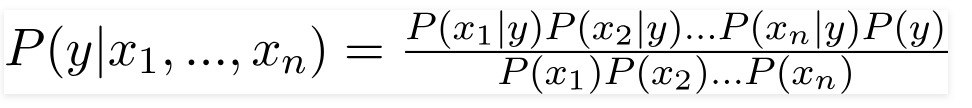

Pour le classificateur binaire, il suffit de multiplier les probabiliter conditionnelle comme au numerateur. Ensuite on peut ignorer le denominateur car il s'agit d'une constante entre les deux probabilités et peut donc etre ignoré. Nous avons pris la decision d'utiliser une loi a priori de 1 pour les deux cas (y = 1 et y = 0). En prenant en compte c'est ensemble de suppositions, on peut conclure que la probabilité conditionnelles pour les surverses s'ecrira :  

Où les deux premieres variables aleatoires sont les precipitations et la troisieme represente l'ouvrage de la surverse. Il faut noter que chaque variable explication est constituer de mesures sur différentes station nous considereron une seul densité et deux methodes seront explorée pour estimer cette densité, la premiere étant un ensemble de normales, on considère alors les différentes mesures comme independantes (bayesian naive) et on multiplie les densité de chaque normale. Avce la deuxieme methode on ne fait pas cette hypothèse et on utilise une seule normale.

### Variable 1 : Precipitation totales par jours

#### Estimation de la densité:

Nous utiliseron les estimateurs de moyenne et de de variance du maximum de vraisemblance pour trouver les parametres de la normale. La premiere colone represente les normales des maximums par jours où il y a eu de surverse. Alors que pour la deuxieme colone il y en a eu. Chaque ligne du tableau indique une station en particulier.

In [305]:
distributions_sum_jour = Array{Normal{Float64}}(undef,n_station,2)
for k in 1:2
    # on filtre sur les surverse, une fois 1 et une fois 0
    y_surverse = filter(row -> row.SURVERSE == F_T[k], copy(data_joined_tot_day))
    for j in 1:n_station
        # on prend les données pour chaques station
        y_ouvrage_station = y_surverse[:, stations[j]]
        distributions_sum_jour[j,k] = Normal(mean(y_ouvrage_station), sqrt(var(y_ouvrage_station)))
    end
end
distributions_sum_jour

5×2 Array{Normal{Float64},2}:
 Normal{Float64}(μ=26.71, σ=67.5456)    Normal{Float64}(μ=187.345, σ=155.008)
 Normal{Float64}(μ=23.006, σ=58.9001)   Normal{Float64}(μ=150.476, σ=136.476)
 Normal{Float64}(μ=29.2324, σ=73.6692)  Normal{Float64}(μ=184.336, σ=160.073)
 Normal{Float64}(μ=23.5763, σ=60.0564)  Normal{Float64}(μ=161.981, σ=137.414)
 Normal{Float64}(μ=23.9182, σ=57.8918)  Normal{Float64}(μ=157.592, σ=122.014)

In [306]:
plot(distributions_sum_jour[1,2], fill=(0,.5,:orange))

┌ Warning: fill is not a recognized aesthetic. Ignoring.
└ @ Gadfly /Users/imranebelhadia/.julia/packages/Gadfly/09PWZ/src/mapping.jl:63


Plot(...)

Une seule normale multivariée est utilisée pourtoutes les stations. On prend ainsi en compte la dependence de la quantité de precipitation mesurée edes différentes stations pour la même variable explicative (ici la somme sur une journée). On considere dependant toujours une independance contitionnelle des différentes variables explicatives.

In [307]:
distributions_sum_jour_multivariate = Array{Any}(undef,2)
for i in 1:2
    # on filtre sur les surverse, une fois 1 et une fois 0
    y_surverse = filter(row -> row.SURVERSE == F_T[i], copy(data_joined_tot_day))[:,2:6]
    #on trouve la matrice de covariance et le vecteur de moyenne
    y_surverse = convert(Matrix,y_surverse)
    moyenne , covar = mean_and_cov(y_surverse,corrected=true)
    distributions_sum_jour_multivariate[i] = MvNormal(vec(moyenne) , (covar))
end

### Variable 2 : precipitaion maximale par jour

Cette variable explicative est traitée exactement de la même manière que la première.

#### Estimation de la denstitée

Une normale est calculée pas station pluviometrique

In [308]:
distributions_max_jour = Array{Normal{Float64}}(undef,n_station,2)
for k in 1:2
    # on filtre sur les surverse, une fois 1 et une fois 0
    y_surverse = filter(row -> row.SURVERSE == F_T[k], copy(data_joined_max_day))
    for j in 1:n_station
        # on prend les données pour chaques station
        y_ouvrage_station = y_surverse[:, stations[j]]
        distributions_max_jour[j,k] = Normal(mean(y_ouvrage_station), sqrt(var(y_ouvrage_station)))
    end
end
distributions_max_jour

5×2 Array{Normal{Float64},2}:
 Normal{Float64}(μ=11.5881, σ=28.0391)  Normal{Float64}(μ=71.373, σ=59.5805) 
 Normal{Float64}(μ=10.4134, σ=26.2891)  Normal{Float64}(μ=59.7042, σ=56.072) 
 Normal{Float64}(μ=13.8848, σ=33.9487)  Normal{Float64}(μ=72.1508, σ=67.3384)
 Normal{Float64}(μ=10.8972, σ=27.4604)  Normal{Float64}(μ=64.8011, σ=56.4929)
 Normal{Float64}(μ=10.6403, σ=25.3677)  Normal{Float64}(μ=60.3007, σ=47.8691)

In [309]:
distributions_max_jour_multivariate = Array{Any}(undef,2)
for i in 1:2
    # on filtre sur les surverse, une fois 1 et une fois 0
    y_surverse = filter(row -> row.SURVERSE == F_T[i], copy(data_joined_max_day))[:,2:6]
    #on trouve la matrice de covariance et le vecteur de moyenne
    y_surverse = convert(Matrix,y_surverse)
    moyenne , covar = mean_and_cov(y_surverse, corrected=true)
    distributions_max_jour_multivariate[i] = MvNormal(vec(moyenne) , (covar))
end
distributions_max_jour_multivariate;

### Variable 3 : ouvrage

Cette variable explicative est discrete. On peut donc estimer la probabilité pour chaqun des cas avec l'estimateur echantillonal pour chaque surverse.

In [310]:
prob_ouvrage = Array{Float64}(undef,n_ouvrages,2)
    
for j in 1:n_ouvrages
    # on filtre sur les surverse, une fois 1 et une fois 0
    y_ouvrage = select(filter(row -> row.NO_OUVRAGE == ouvrages[j], copy(data_joined_max_day)), [:SURVERSE])
    prob = sum(y_ouvrage[:,:SURVERSE]) / size(y_ouvrage[:,:SURVERSE])[1]
    prob_ouvrage[j,:] = [prob 1-prob]
end

## La fonction categorisation utilise le modele entrainé pour effectuer une prediction. 

In [311]:
## in : DATE (permet d'obtenir les precipitation)
## in : is multivariate
## out : 0 => non, 1 => oui
## utilise : propa de chaque V.A utilisées
function categorisation(no_ouvrgages::String, dt::Date, isMultivariate::Bool)
    ## 2. Trouver les données de précipitation pour la date à predire.
    precp_sum = select!(filter(row -> row.date == dt, pcp_sum), [:McTavish, :Bellevue, :Assomption, :Trudeau, :StHubert])
    precp_max = select!(filter(row -> row.date == dt, pcp_max), [:McTavish, :Bellevue, :Assomption, :Trudeau, :StHubert])
    
    ## 3. Trouver mois, numero ouvrage, numero station
    index_ouvrage = index_ouvrages[no_ouvrgages]
    
    ## 4. Evaluer densités normales et probas 
    p₁₁ = 1 
    p₁₂ = 1
    p₁₃ = prob_ouvrage[index_ouvrage,2]
    
    p₀₁ = 1
    p₀₂ = 1
    p₀₃ = prob_ouvrage[index_ouvrage,1]
    
    if isMultivariate
        p₁₁ = pdf(distributions_sum_jour_multivariate[2],vec(convert(Matrix, precp_sum[:,1:5])))
        p₀₁ = pdf(distributions_sum_jour_multivariate[1],vec(convert(Matrix, precp_sum[:,1:5])))
    
        p₁₂ = pdf(distributions_max_jour_multivariate[2],vec(convert(Matrix, precp_max[:,1:5])))
        p₀₂ = pdf(distributions_max_jour_multivariate[1],vec(convert(Matrix, precp_max[:,1:5])))
    else
        for i in 1:n_station
            p₁₁ *= pdf.(distributions_sum_jour[i,2],precp_sum[1,i])[1]
            p₀₁ *= pdf.(distributions_sum_jour[i,1],precp_sum[1,i])[1]

            p₁₂ *= pdf.(distributions_max_jour[i,2],precp_max[1,i])[1]
            p₀₂ *= pdf.(distributions_max_jour[i,1],precp_max[1,i])[1]
        end
     end
    
    ## 5. Multiplier les proba et faire bayes
    p₁ = p₁₁ * p₁₂ * p₁₃
    p₀ = p₀₁ * p₀₂ * p₀₃
    
    return p₁ > p₀ ? 1 : 0
end

categorisation (generic function with 1 method)

In [312]:
categorisation("4240-01D",Date(2019,8,28),true)

0

### Choisisson le modèle qui donne les meilleurs resulats

Si on utilise les normales multivariées:

In [313]:
ŷ = categorisation.(X_test[:,2],X_test[:,1],true)
sum( ŷ .==  X_test[:,3]) / length(ŷ)

0.908

Sinon:

In [314]:
ŷ = categorisation.(X_test[:,2],X_test[:,1],false)
sum( ŷ .==  X_test[:,3]) / length(ŷ)

0.916

On choisis donc d'effectuer nos prediction on utilisation une implementation rigoureuse de la methode Bayesienne naive. Noter que les deux methodes ont été soumise - pour ne pas se fier uniquement sur le test et que la deuxieme a effectivement donner une meilleure solution. 

On construit mantenant notre vecteur de resulats

In [315]:
test = CSV.read("data/test.csv")

# Pour chacune des lignes du fichier test, comportant un ouvrage et une date, une prédiction est requise.
# Dans ce cas-ci, utilisons une prédiction les plus naîve. 
# On prédit avec une chance sur deux qu'il y ait surverse, sans utiliser de variables explicatives
prediction_NAIV_BAYES = []

n = size(test,1)
for i in eachrow(test)
     push!(prediction_NAIV_BAYES, categorisation(i[:NO_OUVRAGE], i[:DATE],false))
end

À l'aide de cette methode prise individuelle, un resultat maximum d'environ 0.74 a été ateinds.

# Création du fichier de prédictions pour soumettre sur Kaggle

Dans ce cas-ci, nous prédirons une surverse avec une probabilité de 1/2 sans considérer aucune variable explicative.

In [316]:
# Création du fichier sampleSubmission.csv pour soumettre sur Kaggle
ID = test[:,:NO_OUVRAGE].*"_".*string.(test[:,:DATE])
sampleSubmission = DataFrame(ID = ID, Surverse=y)
CSV.write("sampleSubmission_hgh.csv",sampleSubmission)

# Vous pouvez par la suite déposer le fichier sampleSubmission.csv sur Kaggle.

"sampleSubmission_hgh.csv"